# This notebook contains the code for Task 1 for the Canadian Dataset

#  Project Setup

Performing the necessary installations

In [ ]:
!pip install lightgbm
!pip install coral_pytorch
!pip install catboost
!pip install deslib
!pip install hyperopt
!pip install git+https://github.com/hyperopt/hyperopt-sklearn
!wget  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!tar xvjf faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
!cp -r lib/python3.6/site-packages/* /usr/local/lib/python3.6/dist-packages/
!pip install mkl
!apt install libomp-dev
!pip install faiss

# !pip install rgf_python
# !pip install --ignore-installed --upgrade tensorflow==2.4.1
# !pip install --force-reinstall --no-deps git+https://github.com/ck37/coral-ordinal/
# !pip install pygam
# !apt install libomp-dev
# !pip install faiss-gpu

  Cloning https://github.com/hyperopt/hyperopt-sklearn to /tmp/pip-req-build-x3bzp6eh
  Running command git clone -q https://github.com/hyperopt/hyperopt-sklearn /tmp/pip-req-build-x3bzp6eh
--2022-03-21 18:22:14--  https://anaconda.org/pytorch/faiss-cpu/1.2.1/download/linux-64/faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2
Resolving anaconda.org (anaconda.org)... 104.17.93.24, 104.17.92.24, 2606:4700::6811:5d18, ...
Connecting to anaconda.org (anaconda.org)|104.17.93.24|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://binstar-cio-packages-prod.s3.amazonaws.com/5a15c9c5c376961204909d87/5aa7f0a65571b411e5c259be?response-content-disposition=attachment%3B%20filename%3D%22faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2%22%3B%20filename%2A%3DUTF-8%27%27faiss-cpu-1.2.1-py36_cuda9.0.176_1.tar.bz2&response-content-type=application%2Fx-tar&X-Amz-Algorithm=AWS4-HMAC-SHA256&X-Amz-Expires=60&X-Amz-Date=20220321T182214Z&X-Amz-SignedHeaders=host&X-Amz-Security-Token=IQoJb

Importing the necessary libraries

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy import mean
from numpy import std
from numpy import arange
from numpy import save

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from scipy.stats import kendalltau
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.utils.class_weight import compute_class_weight
from sklearn import preprocessing
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression


from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier

from hpsklearn import HyperoptEstimator
import faiss

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from deslib.dcs import OLA
from deslib.dcs import MCB
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import METADES
from deslib.des.des_mi import DESMI
from deslib.static import StackedClassifier

from imblearn.over_sampling import SMOTE,BorderlineSMOTE


# from sklearn.base import clone
# from pygam import LogisticGAM, LinearGAM
# import coral_ordinal as coral
# from tensorflow.keras.utils import to_categorical

# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gen_industry_df = pd.read_excel(r'/content/drive/MyDrive/AI Case Study Data/general_industries_df_case_competition_scrambled_train.xlsx', sheet_name='Data')

# Data Preparation

Following tasks have been completed here:

1.   Feature Engineering
2.   Train Test Split
3.   Scaling features
4.   Imputing missing values
5.   Removing outliers
6.   Oversampling to balance classes



### Define functions for creating of new features ( Each function has a comment for its explaination)

In [ ]:
# 3 year averages function
def three_year_average(X, col_y0, col_y1, col_y2, col):
    X.drop(X[X[col_y0].isnull()].index, inplace = True)
    
    X[col] = X[col_y0]
    
    two_years_average = X[col_y1].notnull() & X[col_y2].isnull()
    X.loc[two_years_average, col] = X.loc[two_years_average, col_y0] * 4/7 + X.loc[two_years_average, col_y1] * 3/7
    
    three_years_average = X[col_y1].notnull() & X[col_y2].notnull()
    X.loc[three_years_average, col] = X.loc[three_years_average, col_y0] * 4/9 + X.loc[three_years_average, col_y1] * 3/9 + X.loc[three_years_average, col_y2] * 2/9
    
    return X

# feature engineering fucntion (called later after imputer)
def feat_eng(data_left):
  for i in range(4):
    data_left['DEBT2EBITDA_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['EBITDA_Y' + str(i)]
    data_left['DEBT2CAPT_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['CAPITALIZATION_Y' + str(i)]
    data_left['DEBT2EQUITY_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALEQUITY_Y' + str(i)]
    data_left['DEBT2ASSET_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['DEBT2TANGIBLENW_Y'+str(i)] = data_left['TOTALDEBT_Y'+str(i)] / data_left['tangibleNetWorth_Y' + str(i)]
    data_left['CASH2ASSET_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]
    data_left['CASH2DEBT_Y'+str(i)] = data_left['CCE_Y'+str(i)] / data_left['TOTALDEBT_Y' + str(i)]
    data_left['CA2CL_Y'+str(i)] = data_left['CURRENTASSET_Y'+str(i)] / data_left['CURRENTLIABILITY_Y' + str(i)]

    # Quick (acid-test) ratio = (cash + short term investments + net current recievables ) / current liabilities
    # CCE = cash + short term investments, ARTurnover ~ net current recievables
    data_left['ACIDTESTRATIO_Y'+str(i)] = (data_left['CCE_Y'+str(i)] + data_left['ARTurnover_Y'+str(i)])/ data_left['CURRENTLIABILITY_Y' + str(i)]

    # Inventory Turnover = 365/ inventory days
    data_left['INVENTORYTURNOVER_Y'+str(i)] = 365 / data_left['INVENTORYDAYS_Y' + str(i)]
    # Cost of Goods Sold = Inventory Turnover * Average Inventory
    if 'INVENTORY_Y0' in data_left:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['INVENTORY_Y' + str(i)]
    else:
      data_left['COGS_Y'+str(i)] = data_left['INVENTORYTURNOVER_Y' + str(i)] * data_left['Inventory_Y' + str(i)]

    
    # Cash Conversion Cycle = Inventory Days + Recievable Days - Payable Days
    data_left['CCC_Y'+str(i)] = data_left['INVENTORYDAYS_Y' + str(i)] + data_left['receivabledays_Y' + str(i)] - data_left['payableDAYS_Y' + str(i)]

    # Times Intrest Earned Ratio = operating income/ intrest expense
    # operating profit = operating income - operating expenses (do not have op expenses)
    data_left['TIERATIO_Y'+str(i)] = data_left['OPERPROFIT_Y'+str(i)] / data_left['TOTINTEXP_Y' + str(i)]

    # Return on Assets Ratio = net income / average total assets
    # net income = net profit
    data_left['ROARATIO_Y'+str(i)] = data_left['NETPROFIT_Y'+str(i)] / data_left['TOTALASSET_Y' + str(i)]

    # Enterprise Value = debt + equity - cash
    data_left['EnterpriseValue_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] + data_left['TOTALEQUITY_Y' + str(i)] - data_left['CCE_Y' + str(i)]

    # Retention ratio = retained earnings/ net income
    # net income = net profit
    data_left['RetentionRATIO_Y'+str(i)] = data_left['RETAINED_EARNINGS_Y'+str(i)] / data_left['NETPROFIT_Y'+str(i)] 

  for i in range(3):
    data_left['DEBT2FCF_Y'+str(i)] = data_left['TOTALDEBT_Y' + str(i)] / data_left['FCF_Y'+str(i)]

  data_left['TotalAssetBINS'] = pd.qcut(data_left['TOTALASSET_3YearAverage'], 4, labels=[1,2,3,4]).astype(int)

  relevant_feat = ['TOTALREVENUE_Y', 'CAPITALIZATION_Y', 'TOTALDEBT_Y', 'TOTALASSET_Y', 'NETSALES_Y', 'EBITDA_Y', 'CURRENTASSET_Y', 'FIXEDASSET_Y',
                   'CURRENTLIABILITY_Y', 'NONCURRLIA_Y', 'TOTALEQUITY_Y', 'TOTALNETWORTH_Y', 'TOTINTEXP_Y', 'LEASERENTEXP_Y', 'EBITDAR_Y', 'receivabledays_Y',
                   'INVENTORYDAYS_Y', 'payableDAYS_Y', 'tangibleNetWorth_Y', 'FIXEDCHARGECOV_Y', 'DEBTSERVCOV_Y', 'NETPROFIT_Y',
                   'OPERPROFIT_Y', 'ARTurnover_Y', 'RETAINED_EARNINGS_Y',  'CCE_Y']
  for feat in relevant_feat:
    data_left[feat+'OYGrowth'] = 0

    maskY2 = data_left[feat+str(2)].isnull() & data_left[feat+str(1)].notnull()
    data_left.loc[maskY2, feat+'OYGrowth'] += (data_left.loc[maskY2, feat+str(0)] - data_left.loc[maskY2, feat+str(1)])/data_left.loc[maskY2, feat+str(1)]

    maskY3 = data_left[feat+str(3)].isnull() & data_left[feat+str(2)].notnull()
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(0)] - data_left.loc[maskY3, feat+str(1)])/data_left.loc[maskY3, feat+str(1)]
    data_left.loc[maskY3, feat+'OYGrowth'] += (data_left.loc[maskY3, feat+str(1)] - data_left.loc[maskY3, feat+str(2)])/data_left.loc[maskY3, feat+str(2)]
    data_left.loc[maskY3, feat+'OYGrowth'] = data_left.loc[maskY3, feat+'OYGrowth']/2

    maskAllY = data_left[feat+str(3)].notnull()
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(0)] - data_left.loc[maskAllY, feat+str(1)])/data_left.loc[maskAllY, feat+str(1)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(1)] - data_left.loc[maskAllY, feat+str(2)])/data_left.loc[maskAllY, feat+str(2)]
    data_left.loc[maskAllY, feat+'OYGrowth'] += (data_left.loc[maskAllY, feat+str(2)] - data_left.loc[maskAllY, feat+str(3)])/data_left.loc[maskAllY, feat+str(3)]
    data_left.loc[maskAllY, feat+'OYGrowth'] = data_left.loc[maskAllY, feat+'OYGrowth']/3

  return data_left


# outlier removal function based on z-scores
def remove_outlier(data):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']
    c = []
    for col in data.columns:
        if col not in cols:
            c.append(col)
    for col in c:
        col_zscore = col + '_zscore'
        data[col_zscore] = (data[col] - data[col].mean())/data[col].std(ddof=0)
    data['outlier'] = 'N'
    for index, row in data.iterrows():
        for c in data.columns:
            if 'zscore' in c:
                if abs(row[c]) > 3:
                    data.loc[index, 'outlier'] = 'Y'
                    break
    finaldf = data[data.outlier == 'N']
    cols = []
    for c in data.columns:
        if 'zscore' not in c and c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf

#outlier removal function based on Inter-quartile range
def remove_outlier2(d):
    cols = ['ROW', 'Period', 'B_PLUS_FLAG', 'Final_IG', 'BR Code']    
    c = []
    for col in d.columns:
        if col not in cols:
            c.append(col)
    d['outlier'] = 'N'
    for index, row in d.iterrows():
        print(index)
        for col in c:
            q1 = d[col].quantile(0.25)
            q3 = d[col].quantile(0.75)
            iqr = q3-q1
            if (row[col] >= (q3 + 1.5*iqr)) | (row[col] <= (q1 - 1.5*iqr)) :
                d.loc[index, 'outlier'] = 'Y'
                break
    finaldf = d[d.outlier == 'N']
    cols = []
    for c in d.columns:
        if c != 'outlier':
            cols.append(c)
    finaldf = finaldf[cols]
    return finaldf

### Feature Engineering



*   Remove rows with no Y0 values
*   Replace infinite values
*   Add engineered features



In [ ]:
# sort dataframe
gen_industry_df = gen_industry_df.sort_values(by = ['ROW'], ascending=False)

# extract financial feature names
non_fin_features = ['ROW', 'Corp_Residence_Country_Code', 'BR Code', 'Period', 'CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG']
fin_features = np.sort(list(set(gen_industry_df.columns) - set(non_fin_features)))

# add 3-year averages, and remove rows missing y0 data
cols_to_avg = []

for col in fin_features:
    if (col.endswith('Y0') and not col.endswith('growth_Y0')):
        cols_to_avg.append([col, col[:-2] + 'Y1', col[:-2] + 'Y2', col[:-2] + '3YearAverage'])

data_left = gen_industry_df.copy()
for col0, col1, col2, col in cols_to_avg:
    orig_num_data = len(data_left)
    data_left = three_year_average(data_left, col0, col1, col2, col)
    remaining_data = len(data_left)
    #print((orig_num_data - remaining_data), 'data records are dropped due to ' + col + '\n')

# reset index
data_left = data_left.reset_index(drop = True)

# reset financial features variable to include 3-year avgs
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

# replace infinite values
for col in fin_features:  
  data_left.loc[data_left[col] == -np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].min()
  data_left.loc[data_left[col] == np.inf, col] = data_left.loc[(data_left[col]> -np.inf)&(data_left[col]< np.inf),col].max()

# add engineered features
data_left = feat_eng(data_left)

# recompute list of financial features
fin_features = np.sort(list(set(data_left.columns) - set(non_fin_features)))

### Create Train Test Split

*    Stratify on target
*    Take just financial features for X

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(data_left.drop(['Final_IG', 'B_PLUS_FLAG'], axis=1), data_left[['B_PLUS_FLAG']], test_size=0.25, random_state=42, stratify=data_left[['B_PLUS_FLAG']])

# take just the financial features
X_train = X_train[fin_features]
X_test = X_test[fin_features]

### Scale Features|

*    using Standard Scalar

In [ ]:
# scale features
scaler_train = StandardScaler()
scaler_trained = scaler_train.fit(X_train)
X_train_scaled = scaler_trained.transform(X_train)
X_test_scaled = scaler_trained.transform(X_test)

### Impute Missing Values


*   Using Iterative Imputer



In [ ]:
choice = "train" # options: train, load
# use train if you want to compute the imputed values
if choice == "train":
  # create imputer model to impute missing values, based on training data
  imputer_train = IterativeImputer(max_iter = 3, estimator = ExtraTreesRegressor(n_estimators=10, random_state=42, max_depth=5, min_samples_leaf=10))
  imputer_train.fit(X_train_scaled)
  X_Imputed_Train = imputer_train.transform(X_train_scaled)

  # Use same imputer to impute missing values for testing data
  X_Imputed_Test = imputer_train.transform(X_test_scaled)

  # save to files, to easily access 
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train.npy', X_Imputed_Train)
  save('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test.npy', X_Imputed_Test)
# use load if you want to obtain the values from google drive if already saved once
else:
  # once imputer is run once, just load output from drive
  X_Imputed_Test = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Test.npy')
  X_Imputed_Train = np.load('/content/drive/MyDrive/AI Case Study Data/X_Imputed_Train.npy')

### Oversampling to balance classes

In [ ]:
sm = SMOTE(random_state = 42, k_neighbors=2)
X_train_resampled, y_train_resampled = sm.fit_resample(X_Imputed_Train, np.array(y_train['B_PLUS_FLAG']))

### Outlier Removal

In [ ]:
lof = LocalOutlierFactor(n_neighbors = 5, contamination = 0.02)
yhat = lof.fit_predict(X_train_resampled)
mask = yhat != -1
X_train_resampled, y_train_resampled = X_train_resampled[mask], y_train_resampled[mask]

# Hyperparameter Tuning

The hyperparamter search space has been defined for each of the individual models. The range of each hyperparameter has been specified

In [ ]:
#hyper-parameter space
space_XGBoost={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 42
    }
space_LGBM = {
    'n_estimators': hp.quniform('n_estimators', 100, 200, 1),
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, -1),
    'gamma': hp.quniform('gamma', 0.1, 0.5, 0.1),
    'num_leaves': hp.quniform('num_leaves', 30, 50, 1),
    'reg_alpha': hp.quniform('reg_alpha', 1.1, 1.5, 0.1),
    'reg_lambda': hp.uniform('reg_lambda', 1.1, 1.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 0.5),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),

}
# space_RGF = {
#     'max_leaf': hp.quniform('max_leaf', 1000, 6000, 200),
#     'algorithm': hp.choice('algorithm', ['RGF', 'RGF_Opt', 'RGF_Sib']),
#     'l2': hp.choice('l2', [1, 0.1, 0.01]),
#     'n_tree_search': hp.quniform('n_tree_search', 1, 10, 1)
# }
space_CatBoost = {
     'iterations': hp.quniform('iterations', 10, 1000, 10),
     'depth' : hp.quniform('depth', 1, 8, 1),
     'learning_rate': hp.loguniform('learning_rate', -4, -1),
     'random_strength': hp.loguniform('random_strength', 1e-9, 10),
     'bagging_temperature': hp.uniform('bagging_temperature', 0.0, 1.0),
     'border_count': hp.quniform('border_count', 1, 255, 5),
     'l2_leaf_reg': hp.quniform('l2_leaf_reg', 2, 30, 2),
     'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0)
 }

In [ ]:
#creating objective functions for each model
def objective_XGBoost(space):
    clf=XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
    
    clf.fit(X_Imputed_Train, np.array(y_train).ravel(),
            eval_set=evaluation, eval_metric="logloss",
            early_stopping_rounds=10,verbose=False)
    

    pred = clf.predict_proba(X_Imputed_Test)
    log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
    print ("SCORE:", log_loss_calc)
    return {'loss': log_loss_calc, 'status': STATUS_OK }

#Defining the LGBM classifier
def objective_LGBM(space):
  clf = LGBMClassifier(n_estimators=int(space['n_estimators']),
                         max_depth = int(space['max_depth']),
                         learning_rate=space['learning_rate'],
                         gamma = space['gamma'],
                         num_leaves = int(space['num_leaves']),
                         reg_alpha= space['reg_alpha'],
                         reg_lambda= space['reg_lambda'],
                         colsample_bytree= space['colsample_bytree'],
                         min_child_weight= space['min_child_weight'])
  evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
  clf.fit(X_Imputed_Train, np.array(y_train).ravel(), eval_set=evaluation, eval_metric="logloss",verbose=False)
  pred = clf.predict_proba(X_Imputed_Test)
  log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
  print ("SCORE:", log_loss_calc)
  return {'loss': log_loss_calc, 'status': STATUS_OK }

# def objective_RGF(space):
#   clf = RGFClassifier(
#       max_leaf = int(space['max_leaf']),
#       algorithm = space['algorithm'],
#       loss = 'Log',
#       l2 = float(space['l2']),
#       n_tree_search = int(space['n_tree_search'])
#   )

#   log_loss_calc = cross_val_score(clf, X_Imputed_Train, np.array(y_train).ravel(), cv = 2, scoring = 'neg_log_loss', n_jobs = -1).mean()
#   return {'loss': log_loss_calc, 'status': STATUS_OK }

#Defining the Catboost Classifier
def objective_CatBoost(space):
  clf = CatBoostClassifier(
      iterations = int(space['iterations']),
      depth = int(space['depth']),
      learning_rate = space['learning_rate'],
      random_strength = space['random_strength'],
      bagging_temperature = space['bagging_temperature'],
      border_count = int(space['border_count']),
      l2_leaf_reg = int(space['l2_leaf_reg']),
      class_weights=weights 
  )
  evaluation = [( X_Imputed_Train, np.array(y_train).ravel()), ( X_Imputed_Test, np.array(y_test).ravel())]
  clf.fit(X_Imputed_Train, np.array(y_train).ravel(), eval_set=evaluation, verbose=False)
  pred = clf.predict_proba(X_Imputed_Test)
  log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
  print ("SCORE:", log_loss_calc)
  return {'loss': log_loss_calc, 'status': STATUS_OK }

### Hyperparameter tuning for XGBoost

In [ ]:
#obtaining best hyperparamters
trials = Trials()

best_hyperparams_xgboost = fmin(fn = objective_XGBoost,
                        space = space_XGBoost,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

### Hyperparameter tuning for CatBoost


In [ ]:
trials = Trials()

best_hyperparams_catboost = fmin(fn = objective_CatBoost,
                        space = space_CatBoost,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

### Hyperparameter tuning for LGBM

In [ ]:
trials = Trials()

best_hyperparams_lgbm = fmin(fn = objective_LGBM,
                        space = space_LGBM,
                        algo = tpe.suggest,
                        max_evals = 60, trials = trials)

# Cross validation on individual models

In [ ]:
#best models
xgbModel = XGBClassifier(max_depth=11, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.5558015012270382, gamma = 2.8243813643357636, min_child_weight = 10, reg_alpha = 40, reg_lambda = 0.1358854234543335)
lbm = LGBMClassifier(colsample_bytree = 0.34245267249386596, gamma = 0.2, learning_rate = 0.07035737684282786, max_depth = 8, min_child_weight =  5, n_estimators = 165, num_leaves = 47, reg_alpha = 1.5, reg_lambda = 1.4289364436718857)
cat = CatBoostClassifier(bagging_temperature = 0.6356911273369124, border_count = 170.0, depth = 3.0, iterations = 690.0, l2_leaf_reg = 16.0, learning_rate = 0.09737534180721151, random_strength = 24.837064967401414, scale_pos_weight = 0.4156756373552813)

In [ ]:
# Create StratifiedKFold objects.
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)
xgb_stratified = []
lgbm_stratified = []
catboost_stratified = []

### Cross Validation for XGBoost and test loss

In [ ]:
# run cross validation for XGBoost model
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    xgbModel.fit(x_train_fold, y_train_fold, eval_set=evaluation, eval_metric="logloss",early_stopping_rounds=5,verbose=False)
    pred = xgbModel.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    xgb_stratified.append(log_loss_calc)

In [ ]:
# print average XGBoost validation loss
print("Mean of log loss of xgb Model", mean(xgb_stratified))

Mean of log loss of xgb Model 0.4839926004042473


In [ ]:
# Get test loss
xgbModel.fit(X = X_train_resampled, y = y_train_resampled)
pred_prob = xgbModel.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of xgb Model", log_loss_calc)



Test log loss of xgb Model 0.5167708526933554


### Cross Validation for LGBM and test loss

In [ ]:
# run cross validation for LGBM model *CHANGE X AND Y TO RESAMPLED DATA
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    lbm.fit(X=x_train_fold, y = y_train_fold)
    pred = lbm.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    lgbm_stratified.append(log_loss_calc)

In [ ]:
# print average LGBM validation loss
print("Mean of log loss of lgbm Model", mean(lgbm_stratified))

Mean of log loss of lgbm Model 0.3868258985759381


In [ ]:
# Get test loss
lbm.fit(X = X_train_resampled, y = y_train_resampled)
pred_prob = lbm.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of lbm Model", log_loss_calc)



Test log loss of lbm Model 0.4746784093070079


### Cross Validation for CatBoost and test loss

In [ ]:
# run cross validation for CatBoost model *CHANGE X AND Y TO RESAMPLED DATA
for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    cat.fit(x_train_fold, y_train_fold, eval_set=evaluation)
    pred = cat.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred)
    catboost_stratified.append(log_loss_calc)

0:	learn: 0.6714748	test: 0.6715152	test1: 0.6715152	best: 0.6715152 (0)	total: 79.3ms	remaining: 54.6s
1:	learn: 0.6509376	test: 0.6510021	test1: 0.6510021	best: 0.6510021 (1)	total: 99.1ms	remaining: 34.1s
2:	learn: 0.6318703	test: 0.6319394	test1: 0.6319394	best: 0.6319394 (2)	total: 118ms	remaining: 27s
3:	learn: 0.6144702	test: 0.6145254	test1: 0.6145254	best: 0.6145254 (3)	total: 140ms	remaining: 24s
4:	learn: 0.6015604	test: 0.6016000	test1: 0.6016000	best: 0.6016000 (4)	total: 167ms	remaining: 22.9s
5:	learn: 0.5876615	test: 0.5876884	test1: 0.5876884	best: 0.5876884 (5)	total: 191ms	remaining: 21.8s
6:	learn: 0.5795810	test: 0.5796006	test1: 0.5796006	best: 0.5796006 (6)	total: 214ms	remaining: 20.9s
7:	learn: 0.5743486	test: 0.5743631	test1: 0.5743631	best: 0.5743631 (7)	total: 235ms	remaining: 20s
8:	learn: 0.5689705	test: 0.5689808	test1: 0.5689808	best: 0.5689808 (8)	total: 253ms	remaining: 19.1s
9:	learn: 0.5652789	test: 0.5652869	test1: 0.5652869	best: 0.5652869 (9)	tota

In [ ]:
# print average CatBoost validation loss
print("Mean of log loss of catboost Model", mean(catboost_stratified))

Mean of log loss of catboost Model 0.4544443480910619


In [ ]:
# Get test loss
cat.fit(X = X_train_resampled, y = y_train_resampled)
pred_prob = cat.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of cat Model", log_loss_calc)



0:	learn: 0.6701925	total: 27.1ms	remaining: 18.6s
1:	learn: 0.6486156	total: 56.6ms	remaining: 19.5s
2:	learn: 0.6314735	total: 83.4ms	remaining: 19.1s
3:	learn: 0.6172967	total: 109ms	remaining: 18.7s
4:	learn: 0.6056805	total: 134ms	remaining: 18.4s
5:	learn: 0.5946481	total: 162ms	remaining: 18.5s
6:	learn: 0.5869322	total: 186ms	remaining: 18.2s
7:	learn: 0.5787997	total: 213ms	remaining: 18.2s
8:	learn: 0.5738185	total: 243ms	remaining: 18.4s
9:	learn: 0.5696941	total: 273ms	remaining: 18.6s
10:	learn: 0.5674693	total: 301ms	remaining: 18.6s
11:	learn: 0.5637043	total: 324ms	remaining: 18.3s
12:	learn: 0.5606000	total: 348ms	remaining: 18.1s
13:	learn: 0.5558636	total: 372ms	remaining: 18s
14:	learn: 0.5531808	total: 400ms	remaining: 18s
15:	learn: 0.5492297	total: 432ms	remaining: 18.2s
16:	learn: 0.5447200	total: 465ms	remaining: 18.4s
17:	learn: 0.5437597	total: 501ms	remaining: 18.7s
18:	learn: 0.5423244	total: 523ms	remaining: 18.5s
19:	learn: 0.5408025	total: 548ms	remainin

# Build and Train KNORAE Model


*   Cross validation on the training data file
*   Train final model on entire training file + run predictions on test file



In [ ]:
# define the base models with tuned hyperparameters
weights = [1,0.5,1.2,1.5,2,3,3,3,3,2,1.5,1.2,1.1,1.08,1,1,0.5,1.08]

# define models with best hyperparameters, taken from hyper parameter tuning
classifiers = [
XGBClassifier(max_depth=11, n_estimators=50, eta = 0.001, subsample= 1.0, colsample_bytree=0.5558015012270382, gamma = 2.8243813643357636, min_child_weight = 10, reg_alpha = 40, reg_lambda = 0.1358854234543335),
 LGBMClassifier(colsample_bytree = 0.34245267249386596, gamma = 0.2, learning_rate = 0.07035737684282786, max_depth = 8, min_child_weight =  5, n_estimators = 165, num_leaves = 47, reg_alpha = 1.5, reg_lambda = 1.4289364436718857),
 CatBoostClassifier(bagging_temperature = 0.6356911273369124, border_count = 170.0, depth = 3.0, iterations = 690.0, l2_leaf_reg = 16.0, learning_rate = 0.09737534180721151, random_strength = 24.837064967401414, scale_pos_weight = 0.4156756373552813),
 LogisticRegression()]

# define voting classifiers
voting_classifiers = [#("xgboost", classifiers[0]),
                      ("lgbm", classifiers[1]),
                      ("catboost", classifiers[2]),
                      ("logreg", classifiers[3]) ]


 #fitting model on entire set
for c in classifiers:
	c.fit(X_train_resampled, y_train_resampled)
KNORAE_model = KNORAE(pool_classifiers=classifiers)
# fit the model
KNORAE_model.fit(X_train_resampled, y_train_resampled)


# define k folds
skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

0:	learn: 0.6701925	total: 27.4ms	remaining: 18.9s
1:	learn: 0.6486156	total: 52.7ms	remaining: 18.1s
2:	learn: 0.6314735	total: 81.2ms	remaining: 18.6s
3:	learn: 0.6172967	total: 108ms	remaining: 18.5s
4:	learn: 0.6056805	total: 131ms	remaining: 18s
5:	learn: 0.5946481	total: 159ms	remaining: 18.2s
6:	learn: 0.5869322	total: 183ms	remaining: 17.9s
7:	learn: 0.5787997	total: 210ms	remaining: 17.9s
8:	learn: 0.5738185	total: 240ms	remaining: 18.1s
9:	learn: 0.5696941	total: 268ms	remaining: 18.2s
10:	learn: 0.5674693	total: 291ms	remaining: 18s
11:	learn: 0.5637043	total: 314ms	remaining: 17.7s
12:	learn: 0.5606000	total: 337ms	remaining: 17.6s
13:	learn: 0.5558636	total: 363ms	remaining: 17.5s
14:	learn: 0.5531808	total: 393ms	remaining: 17.7s
15:	learn: 0.5492297	total: 419ms	remaining: 17.7s
16:	learn: 0.5447200	total: 451ms	remaining: 17.8s
17:	learn: 0.5437597	total: 475ms	remaining: 17.7s
18:	learn: 0.5423244	total: 496ms	remaining: 17.5s
19:	learn: 0.5408025	total: 520ms	remainin

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


### Cross Validation - KNORAE Model and additional metrics

In [ ]:

from sklearn.metrics import f1_score

log_loss_knorae = []
custom_loss_meta = []
f1_score_knorae = []
recall_knorae = []
precision_knorae = []
roc_auc_knorae = []

for train_index, test_index in skf.split(X_train_resampled, y_train_resampled):
    x_train_fold, x_test_fold = X_train_resampled[train_index], X_train_resampled[test_index]
    y_train_fold, y_test_fold = y_train_resampled[train_index], y_train_resampled[test_index]
    evaluation = [( x_train_fold, np.array(y_train_fold).ravel()), ( x_train_fold, np.array(y_train_fold).ravel())]
    KNORAE_model.fit(X=x_train_fold, y = y_train_fold)
    print(y_test_fold)
    
    pred_prob = KNORAE_model.predict_proba(x_test_fold)
    log_loss_calc = log_loss(np.array(y_test_fold).ravel(), pred_prob)
    log_loss_knorae.append(log_loss_calc)
    pred = KNORAE_model.predict(x_test_fold)
    f1 = f1_score(y_test_fold, pred, average='binary')
    precision = precision_score(y_test_fold, pred)
    recall = recall_score(y_test_fold, pred)
    auc = roc_auc_score(y_test_fold, pred_prob[:,1])
    recall_knorae.append(recall)
    f1_score_knorae.append(f1)
    precision_knorae.append(precision)
    roc_auc_knorae.append(auc)    


'''
# generate validation loss for just one split - TASK 2/3
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.25, random_state=42, stratify=y_train_resampled)
evaluation = [(X_train, np.array(y_train).ravel()), (X_train, np.array(y_train).ravel())]
model_voting.fit(X=X_train, y = y_train)
pred = model_voting.predict_proba(X_test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred)
custom_loss_calc = custom_loss(np.array(y_test).ravel(), pred)
'''

# print meta model validation log loss - TASK 2
print("Mean of log loss of KNORAE Model", mean(log_loss_knorae))
print("Mean of f1 score of KNORAE MOdel", mean(f1_score_knorae))
print("Mean of recall score of KNORAE MOdel", mean(recall_knorae))
print("Mean of precision score of KNORAE MOdel", mean(precision_knorae))
print("Mean of roc auc score of KNORAE MOdel", mean(roc_auc_knorae))





[0 1 1 ... 0 0 0]
[1 1 1 ... 0 0 0]
Mean of log loss of KNORAE Model 0.3327467944428154
Mean of f1 score of KNORAE MOdel 0.876095024885678
Mean of recall score of KNORAE MOdel 0.8090574250795245
Mean of precision score of KNORAE MOdel 0.9552553966227558
Mean of roc auc score of KNORAE MOdel 0.972180495163052


## Additional performance metrics for KNORAE Model on test data

In [ ]:
# Get test loss
KNORAE_model.fit(X = X_train_resampled, y = y_train_resampled)
pred = KNORAE_model.predict(X_Imputed_Test)
pred_prob = KNORAE_model.predict_proba(X_Imputed_Test)
log_loss_calc = log_loss(np.array(y_test).ravel(), pred_prob)
print("Test log loss of Knorae Model", log_loss_calc)



Test log loss of Knorae Model 0.5104592549707638


In [ ]:
from sklearn.metrics import f1_score
f1_score = f1_score(y_test, pred, average='binary')
print("F1 score for KNORAE Model", f1_score)

F1 score for KNORAE Model 0.7933078645764721


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# precision tp / (tp + fp)
precision = precision_score(y_test, pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, pred)
print('Recall: %f' % recall)

Precision: 0.864733
Recall: 0.732782


In [ ]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef_score = matthews_corrcoef(y_test, pred)
print("Natthews Coefficient Score", matthews_corrcoef_score)

Natthews Coefficient Score 0.35210959449757495


In [ ]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(y_test, pred)
print(matrix)

[[ 907  471]
 [1098 3011]]


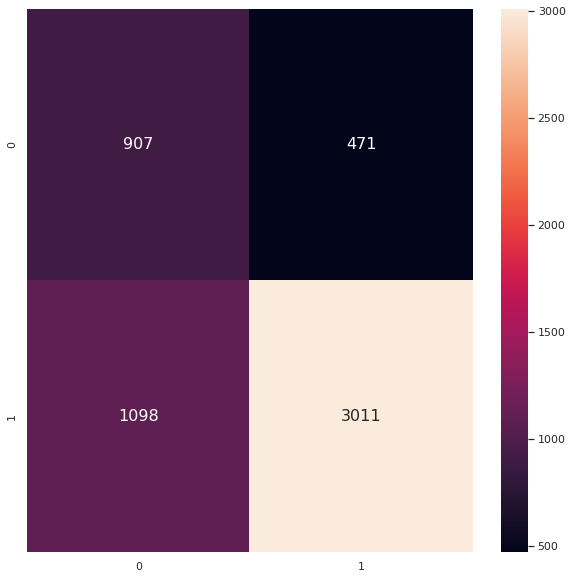

In [ ]:
import seaborn as sn
df_cm = pd.DataFrame(matrix, range(2), range(2))
plt.figure(figsize=(10,10))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, fmt='g', annot_kws={"size": 16}) # font size

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred_prob[:,1])
print('ROC AUC: %f' % auc)

ROC AUC: 0.779545


In [ ]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred_prob[:,0])
print('ROC AUC: %f' % auc)

ROC AUC: 0.220455


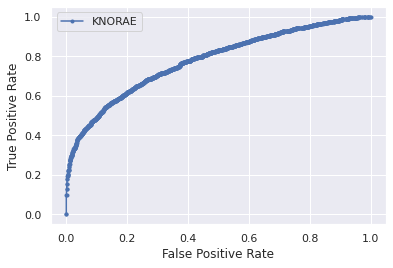

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib import pyplot

probs = pred_prob[:, 1]
# calculate scores
lr_auc = roc_auc_score(y_test, probs)
# summarize scores
# calculate roc curves
lr_fpr, lr_tpr, _ = roc_curve(y_test, probs)
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='KNORAE')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()